# Principle of Maximum Likelihood


## Description:

Python script for illustrating the principle of maximum likelihood and a likelihood fit.

__This is both an exercise, but also an attempt to illustrate four things:__
  1. How to make a (binned and unbinned) Likelihood function/fit.
  2. The difference and a comparison between a Chi-square and a (binned) Likelihood.
  3. The difference and a comparison between a binned and unbinned Likelihood.
  4. What goes on behind the scenes in Minuit, when it is asked to fit something.

In this respect, the exercise is more of an illustration rather than something to be used directly, which is why it is followed later by another exercise, where you can test if you have understood the differences, and how and when to apply which fit method.

The example uses 50 exponentially distributed random times, with the goal of finding the best estimate of the lifetime (data is generated with lifetime, tau = 1). Three estimates are considered:
  1. Chi-square fit (chi2)
  2. Binned Likelihood fit (bllh)
  3. Unbinned Likelihood fit (ullh)

The three methods are based on a scan of values for tau in the range [0.5, 2.0]. For each value of tau, the chi2, bllh, and ullh are calculated. In the two likelihood cases, it is actually -2*log(likelihood) which is calculated, which you should (by now) understand why.
 
Note that the unbinned likelihood is in principle the "optimal" fit, but also the most difficult for several reasons (convergence, numerical problems, implementation, speed, etc.). However, all three methods/constructions essentially yield the same results, when there is enough statistics (i.e. errors are Gaussian), though the $\chi^2$ also gives a fit quality.
 
The problem is explicitly chosen to have only one fit parameter, such that simple 1D graphs can show what goes on. In this case, the analytical solution (simple mean) is actually prefered (see Barlow). Real world problems will almost surely be more complex.

Also, the exercise is mostly for illustration. In reality, one would hardly ever calculate and plot the Chi-square or Likelihood values, but rather do the minimization using an algorithm (Minuit) to do the hard work.

### Reference:
- Barlow, chapter 5 (5.1-5.7)
- Cowan, chapter 6

### Authors: 
- Troels C. Petersen (Niels Bohr Institute, petersen@nbi.dk)

### Date:    
- 21-11-2024 (latest update)

***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
from scipy import stats

## Program settings:

In [2]:
save_plots = False     # Determining if plots are saved or not
verbose = True         # Should the program print or not?
Nverbose = 10          # Print how many?
veryverbose = False    # Should the program print a lot or not?

ScanChi2 = True        # In addition to fit for minimum, do a scan...

# Parameters of the problem:
Ntimes = 50            # Number of time measurements.
tau_truth = 1.0;       # We choose (like Gods!) the lifetime.

# Binning:
Nbins = 50             # Number of bins in histogram
tmax = 10.0            # Maximum time in histogram
binwidth = tmax / Nbins      # Size of bins (s)

# General settings:
r = np.random          # Random numbers
r.seed(42)             # We set the numbers to be random, but the same for each run
plt.rcParams['font.size'] = 16    # Set the default font size


## Generate data:

In [3]:
# Produce array of exponentially distributed times and put them in a histogram:
t = r.exponential(tau_truth, Ntimes) # Exponential with lifetime tau.
yExp, xExp_edges = np.histogram(t, bins=Nbins, range=(0, tmax))

Is the data plotted like we wouls like to? Let's check...

In [4]:
# In case you want to check that the numbers really come out as you want to (very healthy to do at first):
if (veryverbose) :
    for index, time in enumerate(t) :
        print(f"  {index:2d}:   t = {time:5.3f}")
        if index > 10: 
            break # let's restrain ourselves

Looks like values are coming int, but are they actually giving an exponential? Remember the importance of __plotting your data before hand__!

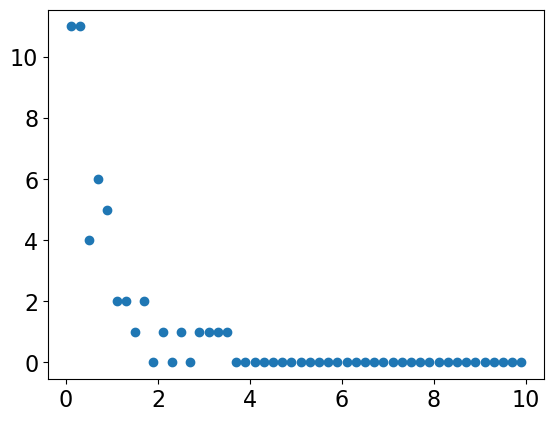

In [5]:
X_center = xExp_edges[:-1] + (xExp_edges[1]-xExp_edges[0])/2.0   # Get the value of the histogram bin centers
plt.plot(X_center,yExp,'o')
plt.show()

Check that it looks like you are producing the data that you want. If this is the case, move on (and possibly comment out the plot!).

## Analyse data:
The following is "a manual fit", i.e. scanning over possible values of the fitting parameter(s) - here luckely only one, tau - and seeing what value of chi2, bllh, and ullh it yields. When plotting these, one should find a <b>parabola</b>, the minimum value of which is the optimal fitting parameter of tau. The rate of increase around this minimum represents the uncertainty of the fitting parameter.

In [6]:
# Define the number of tau values and their range to test in Chi2 and LLH:
# As we know the "truth", namely tau = 1, the range [0.5, 1.5] seems fitting for the mean.
# The number of bins can be increased at will, but for now 50 seems fitting.
Ntau_steps = 50
min_tau = 0.5
max_tau = 1.5
delta_tau = (max_tau-min_tau) / Ntau_steps

In [7]:
# Loop over hypothesis for the value of tau and calculate Chi2 and (B)LLH:
chi2_minval = 999999.9   # Minimal Chi2 value found
chi2_minpos = 0.0        # Position (i.e. time) of minimal Chi2 value
bllh_minval = 999999.9
bllh_minpos = 0.0
ullh_minval = 999999.9
ullh_minpos = 0.0

In [8]:
tau  = np.zeros(Ntau_steps+1)
chi2 = np.zeros(Ntau_steps+1)
bllh = np.zeros(Ntau_steps+1)
ullh = np.zeros(Ntau_steps+1)

In [9]:
# Now loop of POSSIBLE tau estimates:
for itau in range(Ntau_steps+1):
    tau_hypo = min_tau + itau*delta_tau         # Scan in values of tau
    tau[itau] = tau_hypo

    # Calculate Chi2 and binned likelihood (from loop over bins in histogram):
    chi2[itau] = 0.0
    bllh[itau] = 0.0
    for ibin in range (Nbins) :
        # Note: The number of EXPECTED events is the intergral over the bin!
        xlow_bin = xExp_edges[ibin]
        xhigh_bin = xExp_edges[ibin+1]
        # Given the start and end of the bin, we calculate the INTEGRAL over the bin,
        # to get the expected number of events in that bin:
        nexp = Ntimes * (np.exp(-xlow_bin/tau_hypo) - np.exp(-xhigh_bin/tau_hypo))
        # The observed number of events... that is just the data!
        nobs = yExp[ibin]

        if (nobs > 0):      # For ChiSquare but not LLH, we need to require Nobs > 0, as we divide by this:
            chi2[itau] += (nobs-nexp)**2 / nobs                           # Chi2 summation/function
        bllh[itau] += -2.0*np.log(stats.poisson.pmf(int(nobs), nexp))     # Binned LLH function

        if (veryverbose and itau == 0) :
            print(f"  Nexp: {nexp:10.7f}   Nobs: {nobs:3.0f}     Chi2: {chi2[itau]:5.1f}    BLLH: {bllh[itau]:5.1f}")

    # Calculate Unbinned likelihood (from loop over events):
    ullh[itau] = 0.0
    for time in t :     # i.e. for every data point generated...
        ullh[itau] += -2.0*np.log(1.0/tau_hypo*np.exp(-time/tau_hypo))   # Unbinned LLH function
    
    if (verbose and itau < Nverbose) :
        print(f" {itau:3d}:  tau = {tau_hypo:4.2f}   chi2 = {chi2[itau]:6.2f}   log(bllh) = {bllh[itau]:6.2f}   log(ullh) = {ullh[itau]:6.2f}")

    # Search for minimum values of chi2, bllh, and ullh:
    if (chi2[itau] < chi2_minval) :
        chi2_minval = chi2[itau]
        chi2_minpos = tau_hypo
    if (bllh[itau] < bllh_minval) :
        bllh_minval = bllh[itau]
        bllh_minpos = tau_hypo
    if (ullh[itau] < ullh_minval) :
        ullh_minval = ullh[itau]
        ullh_minpos = tau_hypo

   0:  tau = 0.50   chi2 =  12.35   log(bllh) =  71.82   log(ullh) =  99.87
   1:  tau = 0.52   chi2 =  11.52   log(bllh) =  69.30   log(ullh) =  97.29
   2:  tau = 0.54   chi2 =  10.78   log(bllh) =  67.11   log(ullh) =  95.04
   3:  tau = 0.56   chi2 =  10.14   log(bllh) =  65.20   log(ullh) =  93.08
   4:  tau = 0.58   chi2 =   9.59   log(bllh) =  63.55   log(ullh) =  91.38
   5:  tau = 0.60   chi2 =   9.11   log(bllh) =  62.12   log(ullh) =  89.91
   6:  tau = 0.62   chi2 =   8.69   log(bllh) =  60.89   log(ullh) =  88.64
   7:  tau = 0.64   chi2 =   8.34   log(bllh) =  59.84   log(ullh) =  87.55
   8:  tau = 0.66   chi2 =   8.03   log(bllh) =  58.94   log(ullh) =  86.62
   9:  tau = 0.68   chi2 =   7.77   log(bllh) =  58.19   log(ullh) =  85.84


In [10]:
print(f"  Decay time of minimum found:   chi2: {chi2_minpos:7.4f}s    bllh: {bllh_minpos:7.4f}s    ullh: {ullh_minpos:7.4f}s")

  Decay time of minimum found:   chi2:  0.8600s    bllh:  0.8400s    ullh:  0.8400s


In [11]:
print(f"  Chi2 value at minimum:   chi2 = {chi2_minval:.1f}")

  Chi2 value at minimum:   chi2 = 6.8


### Plot and fit results:

In [12]:
# Define range around minimum to be fitted:
min_fit = 0.15
max_fit = 0.20

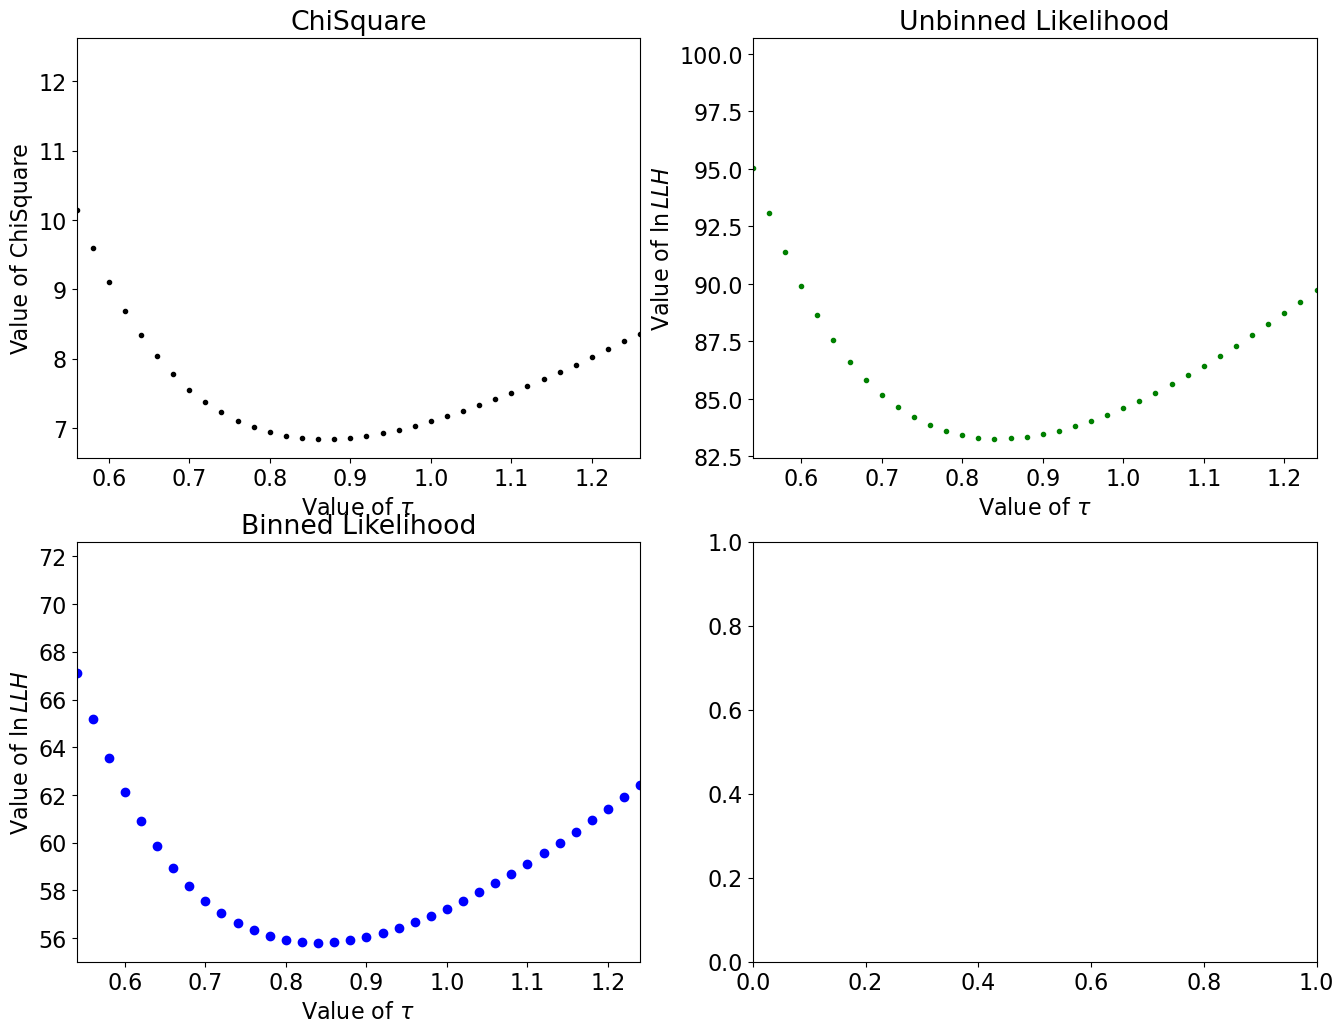

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax_chi2 = axes[0,0]
ax_bllh = axes[1,0]
ax_ullh = axes[0,1]
# A fourth plot is available for plotting whatever you want :)

# ChiSquare:
# ----------
ax_chi2.plot(tau, chi2, 'k.', label='chi2')
ax_chi2.set_xlim(chi2_minpos-2*min_fit, chi2_minpos+2*max_fit)
ax_chi2.set_title("ChiSquare")
ax_chi2.set_xlabel(r"Value of $\tau$")
ax_chi2.set_ylabel("Value of ChiSquare")

# Binned Likelihood:
# ----------
ax_bllh.plot(tau, bllh,'bo')
ax_bllh.set_xlim(bllh_minpos-2*min_fit, bllh_minpos+2*max_fit)
ax_bllh.set_title("Binned Likelihood")
ax_bllh.set_xlabel(r"Value of $\tau$")
ax_bllh.set_ylabel(r"Value of $\ln{LLH}$")

# Unbinned Likelihood:
# ----------
ax_ullh.plot(tau, ullh, 'g.')
ax_ullh.set_xlim(ullh_minpos-2*min_fit, ullh_minpos+2*max_fit)
ax_ullh.set_title("Unbinned Likelihood")
ax_ullh.set_xlabel(r"Value of $\tau$")
ax_ullh.set_ylabel(r"Value of $\ln{LLH}$")

fig;

---
## Parabola function
Note that the parabola is defined differently than normally. The parameters are:
   * `minval`:    Minimum value (i.e. constant)
   * `minpos`:    Minimum position (i.e. x of minimum)
   * `quadratic`: Quadratic term.

In [14]:
def func_para(x, minval, minpos, quadratic) :
    return minval + quadratic*(x-minpos)**2
func_para_vec = np.vectorize(func_para)           # Note: This line makes it possible to send vectors through the function! 

---
## Double parabola with different slopes on each side of the minimum:
In case the uncertainties are asymmetric, the parabola will also be so, and hence needs to be fitted with two separate parabolas meeting at the top point. Parameters are now as follows:
   * `minval`:   Minimum value (i.e. constant)
   * `minpos`:   Minimum position (i.e. x of minimum)
   * `quadlow`:  Quadratic term on lower side
   * `quadhigh`: Quadratic term on higher side

In [15]:
def func_asympara(X, minval, minpos, quadlow, quadhigh):
    return_arr = []
    for x in X: 
        if (x < minpos):
            return_arr.append(minval + quadlow*(x-minpos)**2)
        else :
            return_arr.append(minval + quadhigh*(x-minpos)**2)
    return np.array(return_arr)
func_asympara_vec = np.vectorize(func_asympara)   # Note: This line makes it possible to send vectors through the function! 

## Perform both fits:

In [16]:
# Fit chi2 values with our parabola:
indexes = (tau>chi2_minpos-min_fit) & (tau<chi2_minpos+max_fit)
sy = np.ones_like(tau)

# Fit with parabola:
chi2_object_chi2 = cost.LeastSquares(tau[indexes], chi2[indexes], sy[indexes], func_para)
minuit_chi2 = Minuit(chi2_object_chi2, minval=chi2_minval, minpos=chi2_minpos, quadratic=20.0)
minuit_chi2.migrad()

# Fit with double parabola:
chi2_object_chi2_doublep = cost.LeastSquares(tau[indexes], chi2[indexes], sy[indexes], func_asympara)
minuit_chi2_doublep = Minuit(chi2_object_chi2_doublep, minval=chi2_minval, minpos=chi2_minpos, quadlow=20.0, quadhigh=20.0)
minuit_chi2_doublep.migrad();

6.845951977312518
6.846773722072006


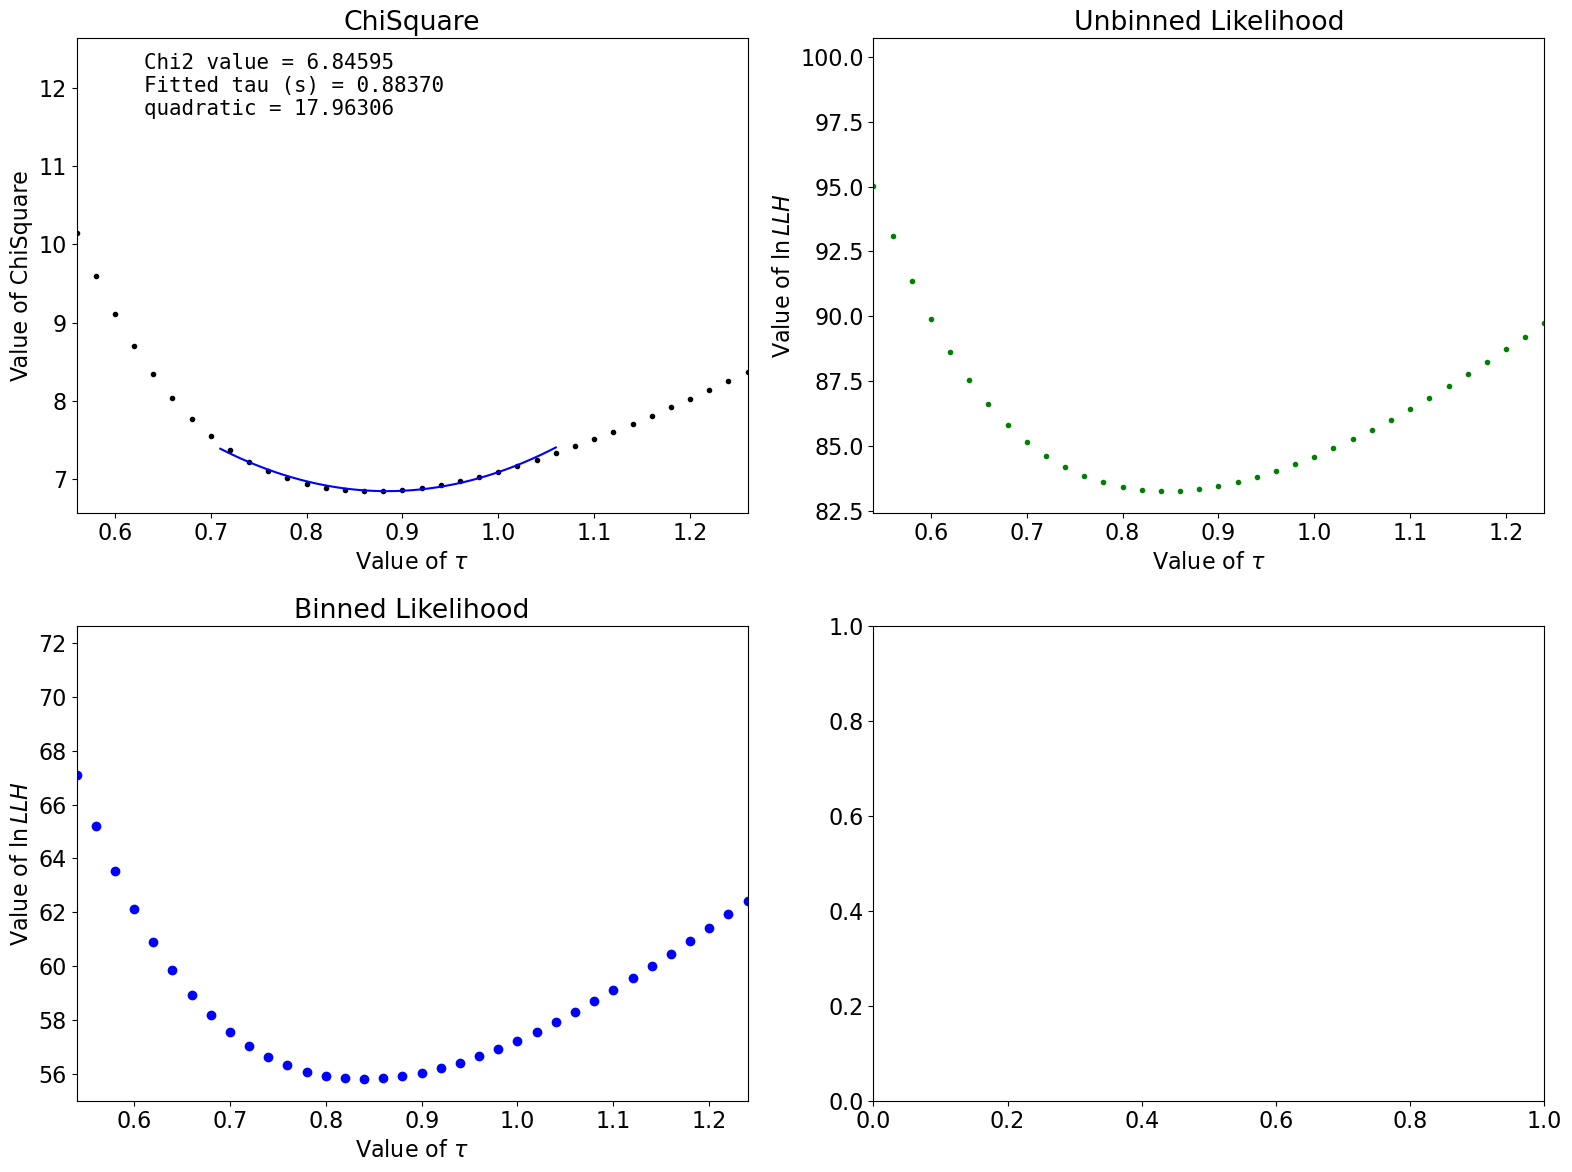

In [17]:
# Plot (simple) fit:
minval, minpos, quadratic = minuit_chi2.values       # Note how one can "extract" the three values from the object.
print(minval)
minval_2p, minpos_2p, quadlow_2p, quadhigh_2p = minuit_chi2_doublep.values
print(minval_2p)
x_fit = np.linspace(chi2_minpos-min_fit, chi2_minpos+max_fit, 1000)
y_fit_simple = func_para_vec(x_fit, minval, minpos, quadratic)
ax_chi2.plot(x_fit, y_fit_simple, 'b-')
plot_info = [f'Chi2 value = {minval:3.5f}',
     f'Fitted tau (s) = {minpos:3.5f}',
     f'quadratic = {quadratic:3.5f}']


ax_chi2.text(0.1, 0.97, "\n".join(plot_info), family='monospace', fontsize=15, verticalalignment='top',transform=ax_chi2.transAxes)
fig.tight_layout()
if save_plots: 
    fig.savefig("FitMinimum.pdf", dpi=600)
fig

In [18]:
# Given the parabolic fit, we can now extract the uncertainty on tau (think about why the below formula works!):
err = 1.0 / np.sqrt(quadratic)
# For comparison, I give one extra decimal, than I would normally do:
print(f"  Chi2 fit gives:    tau = {minpos:.3f} +- {err:.3f}")

# For the asymmetric case, there are naturally two errors to calculate.
#err_lower = 1.0 / np.sqrt(quadlow)
#err_upper = 1.0 / np.sqrt(quadhigh)

  Chi2 fit gives:    tau = 0.884 +- 0.236


In [19]:
# Go through tau values to find minimum and +-1 sigma:
# This assumes knowing the minimum value, and Chi2s above Chi2_min+1
if (ScanChi2) :
    if (((chi2[0] - chi2_minval) > 1.0) and ((chi2[Ntau_steps] - chi2_minval) > 1.0)) :
        found_lower = False
        found_upper = False
        for itau in range (Ntau_steps+1) :
            if ((not found_lower) and ((chi2[itau] - chi2_minval) < 1.0)) :
                tau_lower = tau[itau]
                found_lower = True
                
            if ((found_lower) and (not found_upper) and ((chi2[itau] - chi2_minval) > 1.0)) :
                tau_upper = tau[itau]
                found_upper = True
      
    
        print(f"  Chi2 scan gives:   tau = {chi2_minpos:6.4f} + {tau_upper-chi2_minpos:6.4f} - {chi2_minpos-tau_lower:6.4f}")
    else :
        print(f"  Error: Chi2 values do not fulfill requirements for finding minimum and errors!")

  Chi2 scan gives:   tau = 0.8600 + 0.3200 - 0.1800


### Discussion:
One could here of course have chosen a finer binning, but that is still not very satisfactory, and in any case very slow. That is why we of course want to use e.g. iMinuit to perform the fit, and extract all the relevant fitting parameters in a nice, fast, numerically stable, etc. way.

---

# Fit the data using iminuit (both chi2 and binned likelihood fits)

Now we want to see, what a "real" fit gives, in order to compare our result with the one provided by Minuit.

In [20]:
# Define the function to fit with:
def func_exp(x, N0, tau) :
    return N0 * binwidth / tau * np.exp(-x/tau)

# Define the function to fit with:
def func_exp2(x, N0, tau) : 
    #return N0*(1 - np.exp(-x/tau))
    return N0/tau *np.exp(-x/tau)

### $\chi^2$ fit:

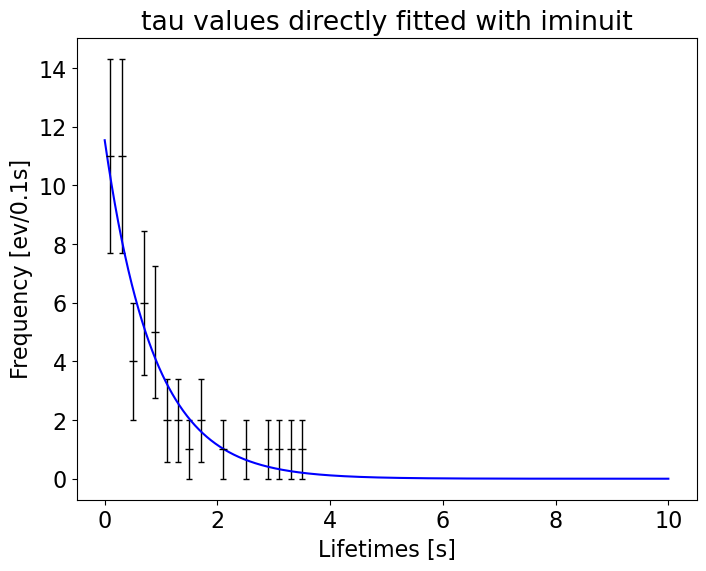

In [21]:
# Prepare figure
fig_fit, ax_fit = plt.subplots(figsize=(8, 6))
ax_fit.set_title("tau values directly fitted with iminuit")
ax_fit.set_xlabel("Lifetimes [s]")
ax_fit.set_ylabel("Frequency [ev/0.1s]")

# Plot our tau values
indexes = yExp>0 # only bins with values!
xExp = (xExp_edges[1:] + xExp_edges[:-1])/2    # Move from bins edges to bin centers
syExp = np.sqrt(yExp)                          # Uncertainties
ax_fit.errorbar(xExp[indexes], yExp[indexes], syExp[indexes], fmt='k_', ecolor='k', elinewidth=1, capsize=2, capthick=1)

# Chisquare-fit tau values with our function:
chi2_object_fit = cost.LeastSquares(xExp[indexes], yExp[indexes], syExp[indexes], func_exp,)
# NOTE: The constant for normalization is NOT left free in order to have only ONE parameter!

minuit_fit_chi2 = Minuit(chi2_object_fit, N0=Ntimes, tau=tau_truth)
minuit_fit_chi2.fixed["N0"] = True
minuit_fit_chi2.migrad()

# Plot fit
x_fit = np.linspace(0, 10, 1000)
y_fit_simple = func_exp(x_fit, *minuit_fit_chi2.values)
ax_fit.plot(x_fit, y_fit_simple, 'b-', label="ChiSquare fit")

In [22]:
# Print the obtained fit results:
# print(minuit_fit_chi2.values["tau"], minuit_fit_chi2.errors["tau"])
tau_fit = minuit_fit_chi2.values["tau"]
etau_fit = minuit_fit_chi2.errors["tau"]

print(f"  Decay time of minimum found:   chi2: {tau_fit:.3f} +- {etau_fit:.3f}s")
print(f"  Chi2 value at minimum:         chi2 = {minuit_fit_chi2.fval:.1f}")

  Decay time of minimum found:   chi2: 0.867 +- 0.236s
  Chi2 value at minimum:         chi2 = 6.8


(array([0.39458818, 0.42714643, 0.45970468, 0.49226293, 0.52482118,
        0.55737943, 0.58993768, 0.62249593, 0.65505418, 0.68761243,
        0.72017068, 0.75272892, 0.78528717, 0.81784542, 0.85040367,
        0.88296192, 0.91552017, 0.94807842, 0.98063667, 1.01319492,
        1.04575317, 1.07831142, 1.11086966, 1.14342791, 1.17598616,
        1.20854441, 1.24110266, 1.27366091, 1.30621916, 1.33877741]),
 array([1.19995279e+01, 9.44775493e+00, 7.38314063e+00, 5.71493322e+00,
        4.37066050e+00, 3.29196499e+00, 2.43159876e+00, 1.75117001e+00,
        1.21940056e+00, 8.10749991e-01, 5.04315728e-01, 2.82948150e-01,
        1.32537090e-01, 4.14363676e-02, 0.00000000e+00, 2.08784379e-04,
        3.53698525e-02, 9.98749983e-02, 1.89006200e-01, 2.98778949e-01,
        4.25815806e-01, 5.67244099e-01, 7.20612884e-01, 8.83825299e-01,
        1.05508321e+00, 1.23284171e+00, 1.41577152e+00, 1.60272777e+00,
        1.79272392e+00, 1.98490983e+00]))

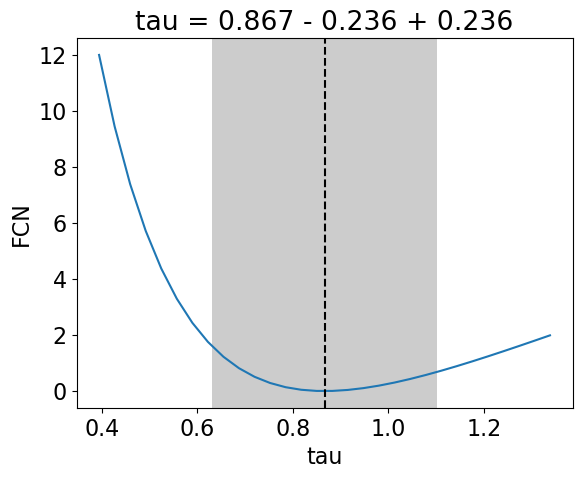

In [23]:
# Alternatively to the above, one can in iMinuit actually ask for the Chi2 curve to be plotted by one command:
minuit_fit_chi2.draw_mnprofile('tau')

---

### Binned likelihood fit:

Below is an example of a binned likelihood fit. Try to write an unbinned likelihood fit yourself!

/var/folders/2n/_6gp5csx2h95th8hs9wnmldr0000gn/T/ipykernel_37845/2322453727.py:8: RuntimeWarning: overflow encountered in exp
  return N0/tau *np.exp(-x/tau)
/opt/anaconda3/envs/appstat24/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1515: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


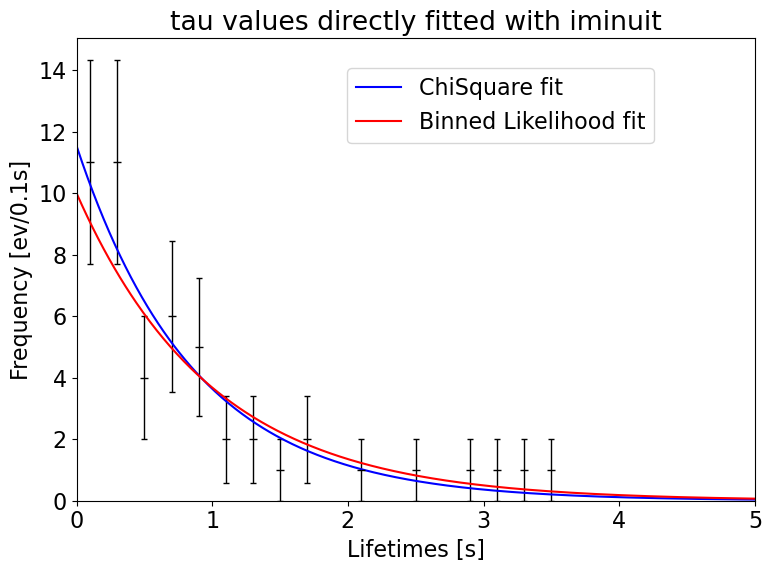

In [24]:
# Binned likelihood-fit tau values with our function
# extended=True because we have our own normalization in our fit function
bllh_object_fit = cost.BinnedNLL(t, xExp_edges, func_exp2)
minuit_fit_bllh = Minuit(bllh_object_fit, tau=tau_truth, N0=Ntimes)
minuit_fit_bllh.migrad()

# Plot fit
N0, tau_fit_bllh = minuit_fit_bllh.values
x_fit = np.linspace(0, 10, 1000)
y_fit_simple = func_exp(x_fit, N0, tau_fit_bllh)
ax_fit.plot(x_fit, y_fit_simple, 'r-', label="Binned Likelihood fit")

# Define the ranges:
ax_fit.set_xlim(0, 5)
ax_fit.set_ylim(bottom=0)     # We don't want to see values below this!
fig_fit.legend(loc=[0.45, 0.75])
fig_fit.tight_layout()
fig_fit

In [25]:
if (save_plots) :
    fig_fit.savefig("ExponentialDist_Fitted.pdf", dpi=600)

---

# Questions:

1) Consider the four plots (bottom right one empty) showing chi2, bllh, and ullh as a function of lifetime, tau. Do the four curves resemble each other in shape? Are they identical in shape? Do the three methods give similar results, or are they different? Do you see the relation between the curves and the fit result? This question requires that you also fit a parabola to the other two cases. Remember to consider both central value and uncertainty of tau.

2) Now consider the two (chi2 and bllh) fits by iMinuit. How alike results do they obtain? Again, consider both the central values and the uncertainty.

3) Try to decrease the number of exponential numbers you consider to say 10, and see how things change. Does the difference between Chi2, bllh, and ullh get bigger or not?

4) Try to increase the number of exponential numbers you consider to say 10000, and see what happens to the difference between Chi2 and BLLH? Also, does the errors become more symetric? Perhaps you will need to consider a shorter range of the fit around the mimimal value, and have to also increase the number of points you calculate the chi2/bllh/ullh (or decrease the range you search!), and possibly change the ranges of your plotting.


### Advanced Questions:

5) Make (perhaps in a new program) a loop over the production of random data,
   and try to see, if you can print (or plot) the Chi2 and BLLH results for each
   turn. Can you spot any general trends? I.e. is the Chi2 uncertainty always
   lower or higher than the (B/U)LLH? And are any of the estimators biased?

6) Make a copy of the program and put in a different PDF (i.e. not the exponential).
   Run it, and see if the errors are still asymetric. For the function, try either
   e.g. a Polynomial or a Gaussian.

# Learning points:

Make sure that you understand how the likelihood is different from the ChiSquare,
and how the binned likelihood is different from the unbinned. If you don't do it,
this exercise, and much of the course and statistics in general will be a bit lost
on you! :-)

You should understand that the binned likelihood fit resembels the ChiSquare fit a bit,
only the evaluation in each bin is different, especially if the number of events in the bin is low,
as the PDF considered (Poisson for the LLH, Gaussian for the ChiSquare) is then different.
At high statistics, they give the same result, but the ChiSquare fit quality can be evaluated.

Also know that the unbinned likelihood uses each single event, and is thus different at its core.
This can make a difference, if there are only few events and/or if each event has several
attributes (e.g. uncertainties in x and y), which can't be summarized in a simple histogram with bins.

Finally, uncertainties can be asymmetric (from low statistics and/or asymmetric fit), but usually
they are not.


## Conclusion:
Fitting "manually" is damn hard, cumbersome, and not a thing that one wants to do.
Always let a well tested program (e.g. iMinuit or SciPy Optimize) do it, and instead
take the inspired position of checking that the fitting program actually is doing
what it is supposed to do, and that everything comes out reasonable.

The art of fitting is multiple. **Very importantly, a fit requires good input parameters**,
as it will otherwise not converge. Also, the Chi-square fit is more robust, so it is often
a good idea to start with this, and if the fit converges, one can use the fitting parameters
as input values for subsequent (likelihood) fits. Finally, one needs to consider the binning
and fitting range carefully, and make good use of the p-value from the Chi-square fit.